# ANN for regression, exercise project 1 - Diamonds

<b>THIS IS A NEWER VERSION</b><br>
I realized in the original notebook, that the there is redundancy in the dataset, since the depth can be calculated using x, y and z.
This is a small correction, where x,y and z were removed to see if fixing this redundancy helps the model.
The comments have not been edited, but looking roughly through the code, it does not change much, yet it shows that some models are now better than others.
So this error has significance.

## Dependancies

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [2]:
df = pd.read_csv("data/diamonds.csv")

In [3]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df = df.drop("Unnamed: 0", axis=1)
df = df.drop("x", axis=1)
df = df.drop("y", axis=1)
df = df.drop("z", axis=1)

In [5]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
dtype: int64

## Categorial variables

The dataset appears to have a few categorial variables, but looking at the notes of the original uploader of the dataset, it is implied that they are ordinal categories.

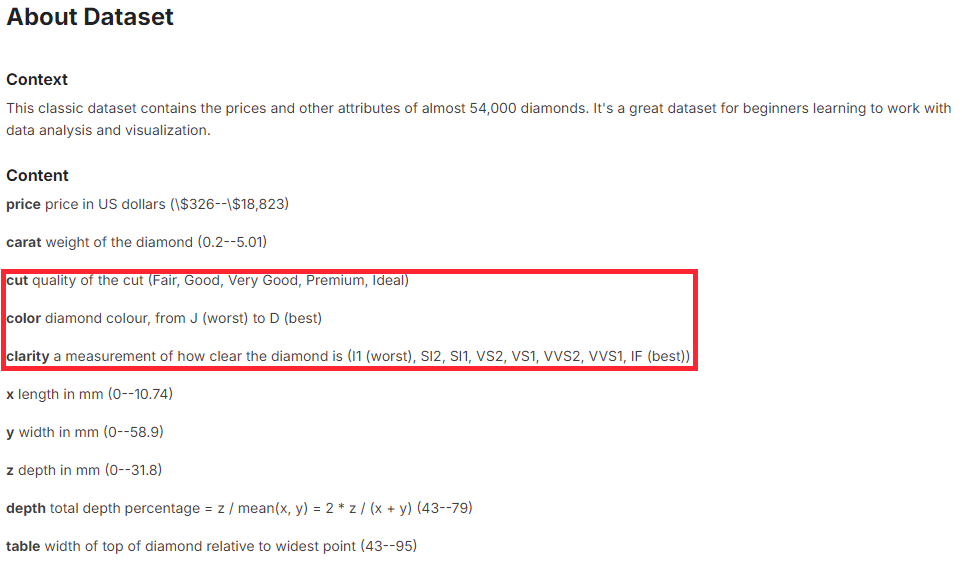

In [6]:
df['cut'].value_counts()

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

In [7]:
df['color'].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [8]:
df['clarity'].value_counts()

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

In [9]:
# Defining the map function
def binary_map_cut(x):
    return x.map({"Fair": 0, "Good": 1, "Very Good": 2, "Premium":3, "Ideal":4})

# Defining the map function
def binary_map_color(x):
    return x.map({"J": 0, "I": 1, "H": 2, "G": 3, "F":4, "E":5, "D":6})

# Defining the map function
def binary_map_clarity(x):
    return x.map({"I1":0, "SI2":1,"SI1":2,"VS2":3,"VS1":4,"VVS2":5,"VVS1":6,"IF":7})

# Applying the function to the housing list
df[["cut"]] = df[["cut"]].apply(binary_map_cut)
df[["color"]] = df[["color"]].apply(binary_map_color)
df[["clarity"]] = df[["clarity"]].apply(binary_map_clarity)

In [10]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


## Scaling the values

I will leave this out for now, this gave me weird results, I don't think that these values should be scaled.

In [11]:
# num_vars = ['carat', 'cut', 'color', 'clarity', 'depth', 'table','price','x','y','z']

# from sklearn.preprocessing import MinMaxScaler
# scaler_with_price = MinMaxScaler()
# df[num_vars] = scaler_with_price.fit_transform(df[num_vars])

## Creating the regression model

In [12]:
# printing out the column names for easier copying for X/y
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price'], dtype='object')

In [13]:
# define independent variable
X = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table']]

# define dependant variable
y = df['price']

In [14]:
# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.
# if you want to split the test set into two for a validation set too, try this trick:

# first, train/test split => 70% for training, 30% for other purposes (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# now, split the 30% for other purposes by 50% (resulting in 2 x 15%)
# so finally, we have:
# 70% for training
# 15% for testing
# 15% for validation
# => 70 + 15 +15 = 100%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [15]:
variable_amount = len(X.columns)

In [16]:
# just seeing how much data we have in each
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 37758
Test data amount: 8091
Validation data amount: 8091


### First Model

First, let's just try to stick to layers with a high node count.

In [17]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(64, input_shape=(variable_amount,)),  # 1st layer with 64 neurons
        layers.Dense(128),  # 2nd layer with more neurons to learn complex patterns
        layers.Dense(64),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 16149227.0000 - val_loss: 2043262.2500
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1704368.8750 - val_loss: 1592349.3750
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1628085.7500 - val_loss: 1651956.3750
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1603634.7500 - val_loss: 1574067.7500
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1627402.0000 - val_loss: 1575643.2500
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1615396.3750 - val_loss: 1771141.1250
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1613395.8750 - val_loss: 1702335.7500
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1592316.5000 - val_loss: 1526282.8750
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1626850.8750 - val_loss: 1580350.2500
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1551271.2500 - val_loss: 1718011.125

In [19]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
1623866.625

Train data evaluation:
1580937.125


These numbers are only around 40 000$ apart.

In [20]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Test True Y,Model Predictions
0,3407,3855.312012
1,11631,8379.757812
2,18741,13593.048828
3,2285,3251.137451
4,648,-608.292480
...,...,...
8086,1985,2495.812744
8087,475,-820.645447
8088,2351,1969.340088
8089,945,785.733704


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

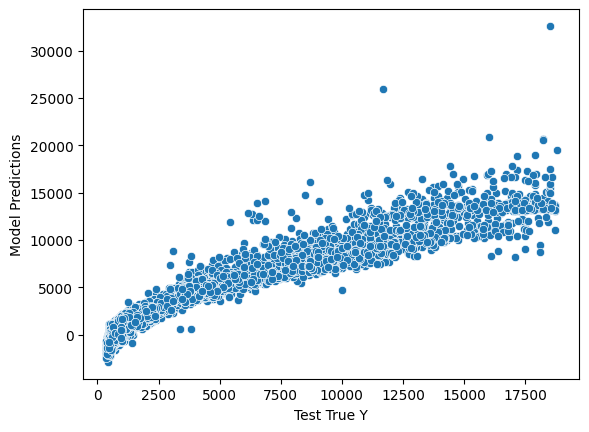

In [21]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

This scatterplot is very messy, there seems to be a coherant line following through the plot, but it's way to unorganized.

In [22]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
846.9 $

MSE
1623866.39 $^2

RMSE:
1274.31 $

R-squared:
0.9

Explained variance score:
0.91


These are pretty good numbers.

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


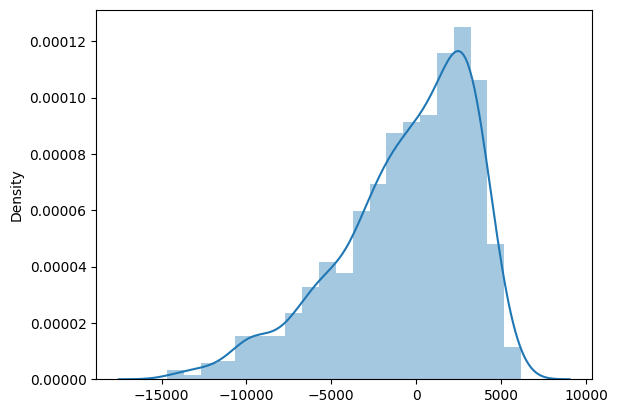

In [23]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

This looks like a pretty normal distribution.

In [24]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [25]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

To test how accurate the prediction is, I also put these stats into various online calculators:

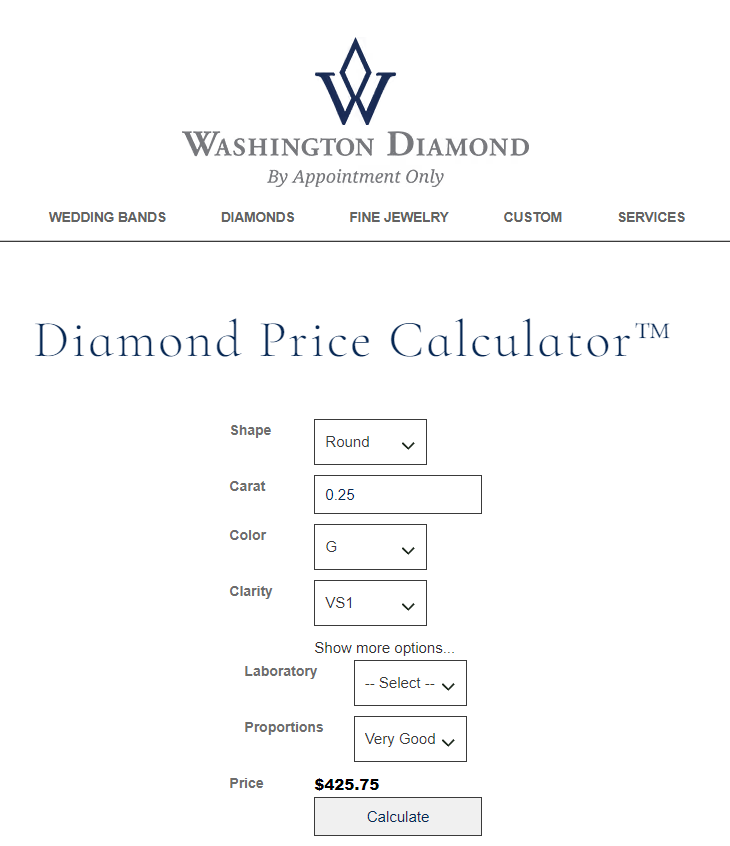

https://www.washingtondiamond.com/diamond-price-calculator

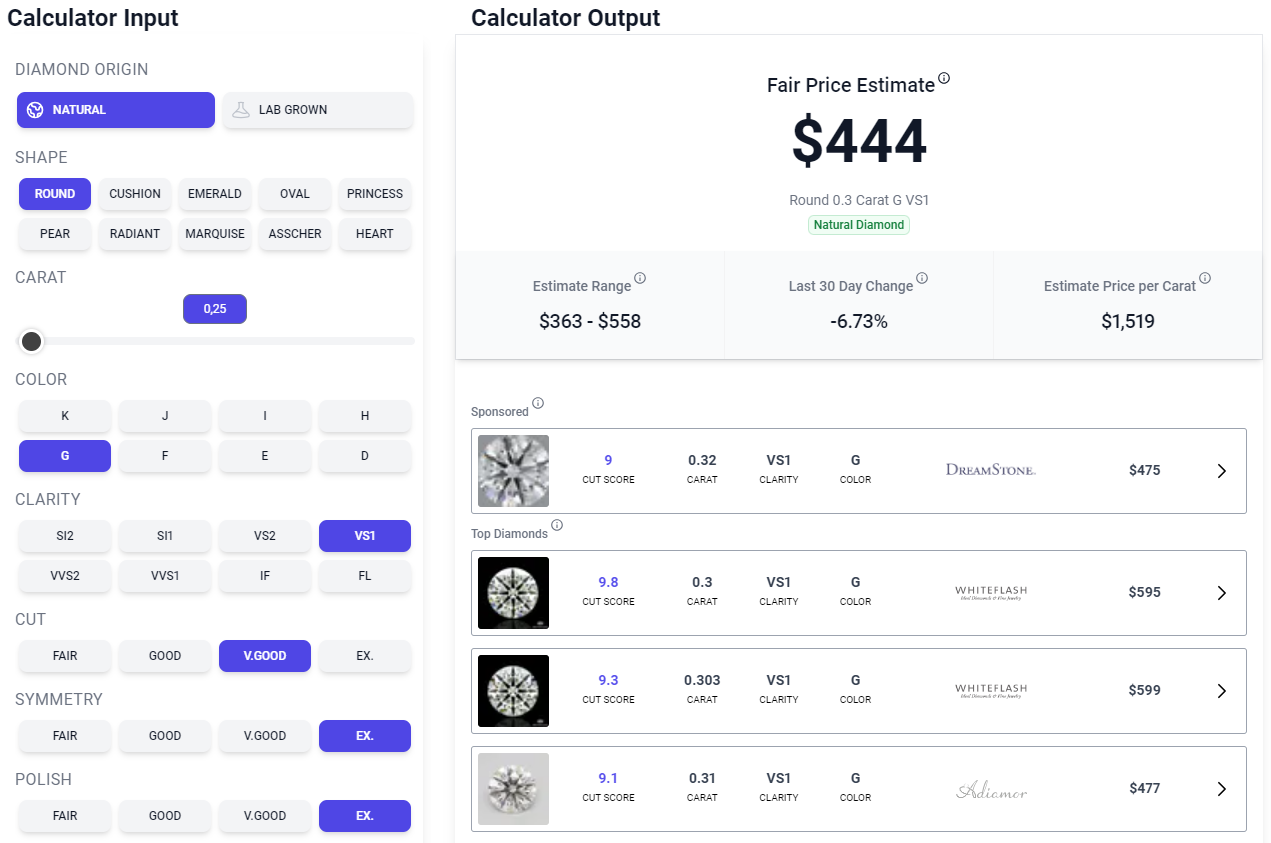

https://www.stonealgo.com/diamond-price-calculator/calc?a=1&b=0.3&c=5&d=4&e=3&f=4&g=4&h=5&i=0

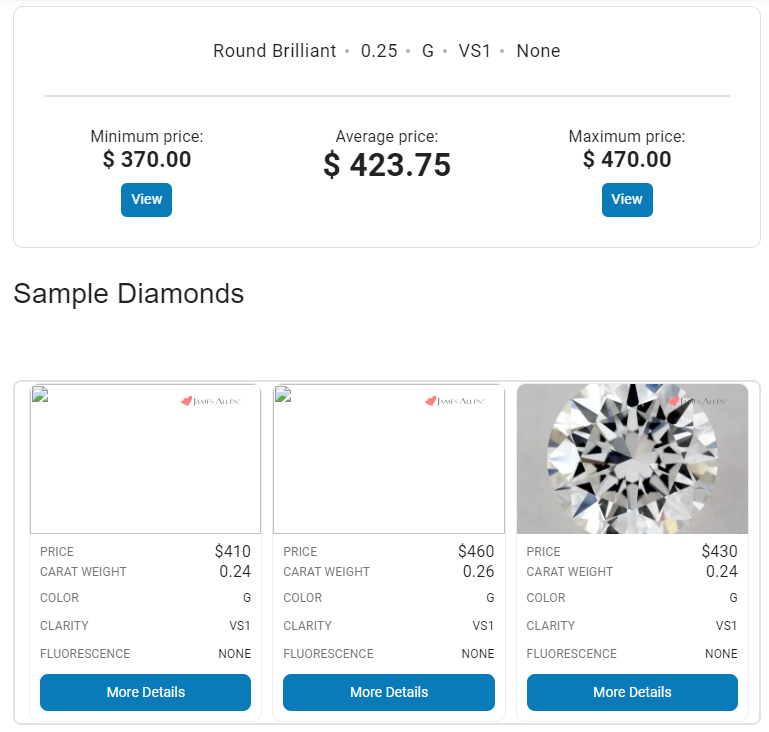

https://www.diamonds.pro/education/diamond-price-calculator/

I have also used these online tools to test if some prices of the diamonds from the dataset could be guessed correctly.<br>
And in many instances the online tools were able to guess very good, being only around 10% off of the actual prices. Which means these tools CAN be very accurate.

Which could suggest that the actual price of the sample diamond for the estimation would be around 430$.

In [26]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Estimated price for this diamond:
-1298.21 $
----------------


This model seems very broken.

In [27]:
len(y_test)

8091

### Second Model

Let's try to add a few dropouts to avoid overfitting.

In [28]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=(variable_amount,)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu"),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu"),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 17646928.0000 - val_loss: 10636013.0000
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6646768.0000 - val_loss: 1100101.3750
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1417696.7500 - val_loss: 952211.1250
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1295444.6250 - val_loss: 1037274.4375
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1157547.3750 - val_loss: 990538.5625
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1071378.8750 - val_loss: 816159.1875
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1080957.0000 - val_loss: 787161.5625
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 991556.0000 - val_loss: 758744.2500
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1024998.1250 - val_loss: 794700.1875
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 990290.1875 - val_loss: 765117.1250
Epoch 

<Axes: >

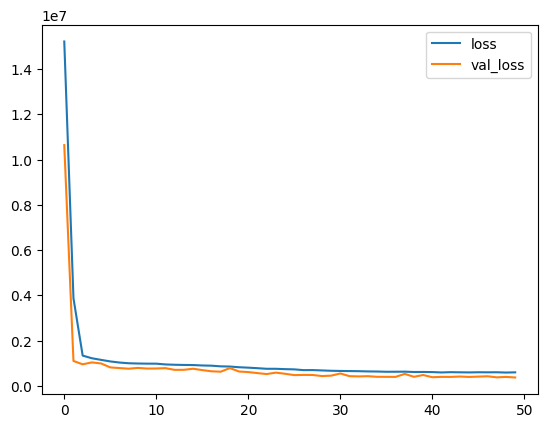

In [30]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

Since validation loss is above the training loss, this could suggest that this model has a lot of overfitting.

In [31]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
399140.9375

Train data evaluation:
369551.03125


They are only 100 000 values apart, that's not that bad.

In [32]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test True Y,Model Predictions
0,3407,3917.468750
1,11631,11329.285156
2,18741,16398.371094
3,2285,2802.541504
4,648,626.699341
...,...,...
8086,1985,2088.129395
8087,475,714.617615
8088,2351,2117.898193
8089,945,1291.220093


The guesses seem to be very close sometimes.

<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

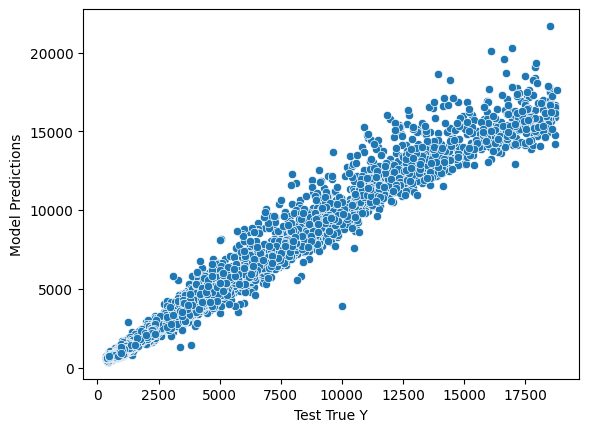

In [33]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

The scatterplot also seems to have a logical line that it follows, there are a few extreme outliers though. Also, it seems the more expensive the diamonds get, the less accurate the predictions are.<br>
The reason for this could be, that higher priced diamonds get a bit more complex when it comes to pricing. Since there can be more factors catering into that, for example the brand, rarity, historical relevance, luxury value, market demand etc.<br>
This could also explain some of the outliers.<br>
If we examine the scatterplot closely, we can see, that the logical line gets less accurate and doesn't line up that well after around 10 000$. The model seems to underpredict a lot of values here.

In [34]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
360.85 $

MSE
399140.82 $^2

RMSE:
631.78 $

R-squared:
0.98

Explained variance score:
0.98


We already have some pretty good values here, although the MAE seems to be pretty high, considering that the prices for the diamonds ranges from 326$ up to 18 823$.<br>
RMSE is also pretty high, but R-squared and the explained variance score are already pretty high, meaning we're really close to creating the most accurate model.

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


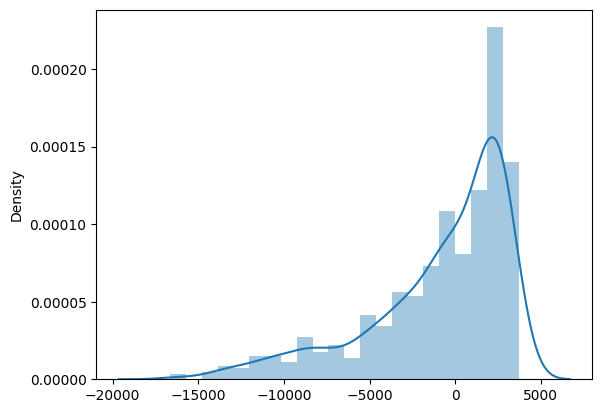

In [35]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

This plot has weird distributions. I mean you could somewhat say it's distribution is normal, since both sides are balanced when you look at the numbers distributed on both sides.<br>
But somehow..
<ul>
 <li>when underpredicting the values, the model seems to be very consistent and dense.</li>
 <li>when overpredicting the values, the model seems to get very inconsistend and complex.</li>
 </ul>

 The amount it overpredicts is also very high, considering the underpredicting never passes 5 000$ while overpredicting  reaches up to 15 000$ divergence.<br>
 We already saw a pattern for this in the scatterplot, it seems that the model gets very inconsistend in the higher price ranges. It could be, that the dataset does not have that many accurate high priced examples to learn accurate predictions. This could be an explanation for the high amount of variance.

In [36]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [37]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [38]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Estimated price for this diamond:
719.29 $
----------------


This is 230$ too high.

In [39]:
len(y_test)

8091

### Third model

The first model already seems kind of accurate, but it has it's problems.<br>
Let's try to add a batch normalization to maybe even out the higher values a bit.

In [40]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(64, activation="relu"),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu"),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu"),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,113 (66.85 KB)

 Trainable params: 17,101 (66.80 KB)

 Non-trainable params: 12 (48.00 B)

In [41]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 13110518.0000 - val_loss: 1136519.3750
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2067993.2500 - val_loss: 1049342.8750
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2017106.1250 - val_loss: 1075861.5000
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1892731.2500 - val_loss: 975265.1250
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1886591.6250 - val_loss: 961236.8750
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1974675.1250 - val_loss: 978129.3125
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1898123.6250 - val_loss: 929615.7500
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1800635.0000 - val_loss: 924256.6875
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1795768.7500 - val_loss: 924076.8750
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1865476.8750 - val_loss: 915672.1875
Epoch

<Axes: >

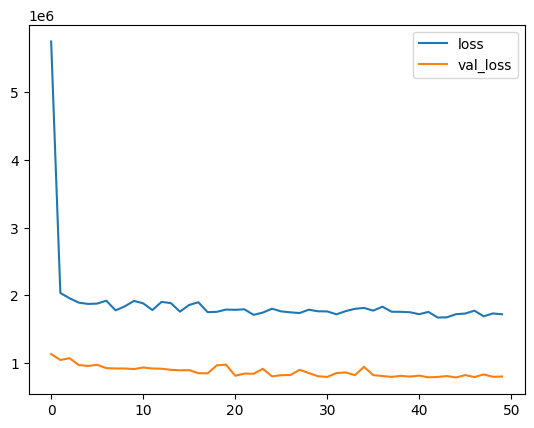

In [42]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

It seems that with the batch normalization we got rid of the heavy overfitting.

In [43]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
814462.5625

Train data evaluation:
790720.5


The difference between those two got higher, to around 125 000$. It's only 25 000$ higher though.

In [44]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Test True Y,Model Predictions
0,3407,3588.639893
1,11631,10794.237305
2,18741,14796.111328
3,2285,2412.049072
4,648,654.156799
...,...,...
8086,1985,1762.409790
8087,475,620.269775
8088,2351,2137.952637
8089,945,1014.780396


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

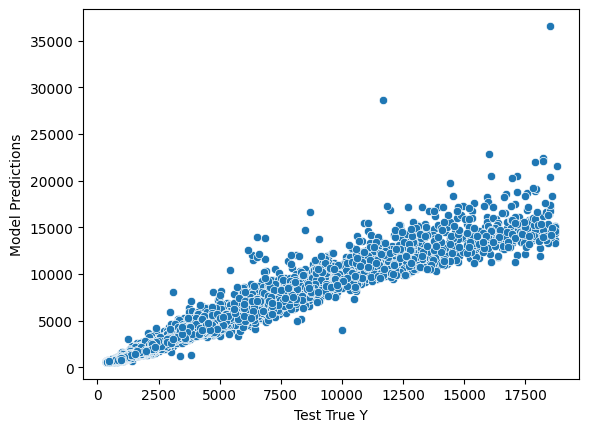

In [45]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

The scatterplot doesn't seem to have changed that much, it still gets very inaccurate after around 10 000$. And there seems to be a few very strong outliers.

In [46]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
467.07 $

MSE
814462.56 $^2

RMSE:
902.48 $

R-squared:
0.95

Explained variance score:
0.95


These values seem to have changed quite a bit. With both lower MAE and RMSE and higher R-squared and explained variance score. So the batch normalization helped to get the data a bit more consistend.

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


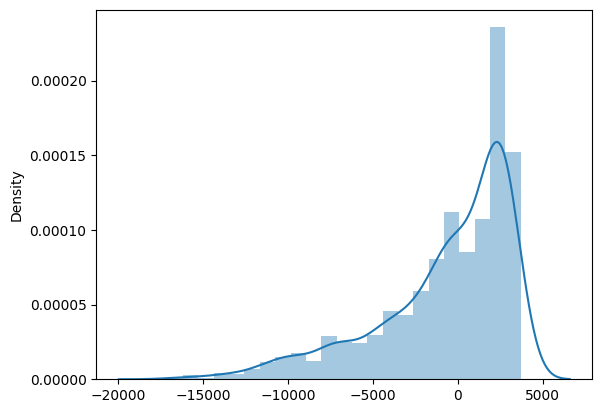

In [47]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

This still looks kind of the same as before, but it got a bit more consistend at around -10 000$.

In [48]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [49]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [50]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Estimated price for this diamond:
663.68 $
----------------


The estimated price got doubled. It's now around 800$ more than the other estimation.

In [51]:
len(y_test)

8091

### Fourth model

Since overfitting seemed to be a problem in the first model, we could also try to use a few l2 regularizers to counter this.

In [52]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(64, input_shape=(variable_amount,), activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 18235630.0000 - val_loss: 10198276.0000
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5906825.0000 - val_loss: 1149567.5000
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1314122.0000 - val_loss: 950572.6875
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1189281.8750 - val_loss: 856948.5625
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1068122.6250 - val_loss: 799649.7500
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1086001.0000 - val_loss: 804633.7500
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1016960.7500 - val_loss: 752763.3750
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 966788.8125 - val_loss: 787633.5000
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 976408.0625 - val_loss: 763966.1250
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 954035.8750 - val_loss: 781185.9375
Epoch 11

<Axes: >

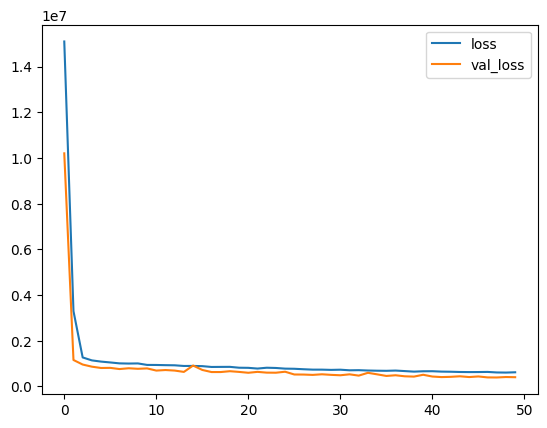

In [54]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

It still has a bit of overfitting, but it is lower than the first model.

In [55]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
418675.71875

Train data evaluation:
391419.6875


The numbers are now only 90 000$ apart, which is even less than the first model.

In [56]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Test True Y,Model Predictions
0,3407,3790.788574
1,11631,11361.837891
2,18741,16253.153320
3,2285,2750.392334
4,648,703.883667
...,...,...
8086,1985,2112.841309
8087,475,700.757996
8088,2351,2406.733887
8089,945,1481.490479


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

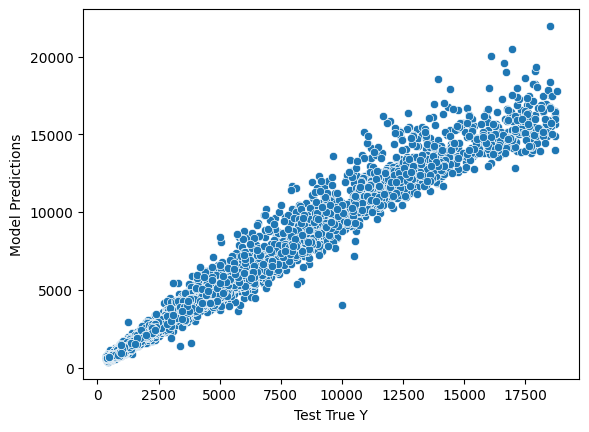

In [57]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

The scatterplot still seems to have the same problem, where it gets inaccurate after 10 000$, but it seems that a few outliers try to balance that.

In [58]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
385.21 $

MSE
418372.02 $^2

RMSE:
646.82 $

R-squared:
0.97

Explained variance score:
0.97


The numbers are all pretty good, but these are still the worst numbers we had until now.

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


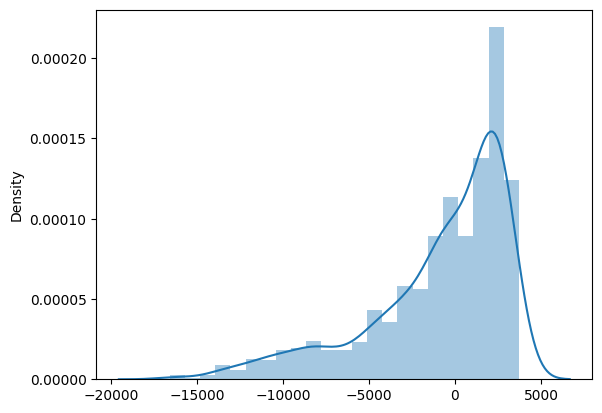

In [59]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

Still the same problem, doesn't seem to be managed that well without the batch normalization.

In [60]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [61]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [62]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Estimated price for this diamond:
701.62 $
----------------


This is closer to the actual estimated diamond, it's now only 200$ off.

In [63]:
len(y_test)

8091

### Fifth model

Since the batch normalization helped a bit by balancing a few numbers and the regularizers helped the overfitting, let's try to combine those two.

In [64]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,113 (66.85 KB)

 Trainable params: 17,101 (66.80 KB)

 Non-trainable params: 12 (48.00 B)

In [65]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 13371388.0000 - val_loss: 1121088.2500
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1950739.8750 - val_loss: 981805.1875
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1936318.1250 - val_loss: 978444.5000
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1843510.2500 - val_loss: 895570.0625
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1860777.5000 - val_loss: 859459.1875
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1761038.7500 - val_loss: 1068395.0000
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1683055.6250 - val_loss: 829034.9375
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1800762.6250 - val_loss: 847760.1875
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1786395.7500 - val_loss: 809266.0000
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1889835.5000 - val_loss: 864813.3125
Epoch 

<Axes: >

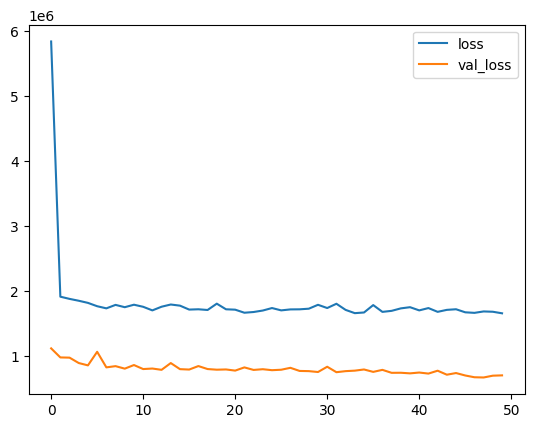

In [66]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

This distplot looks very similiar to the one from the second model, but it seems as though the distance between the validation loss and the training loss is a bit shorter.

In [67]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
727249.4375

Train data evaluation:
701060.6875


These numbers are now only 80 000$ apart, that's the best one yet.

In [68]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Test True Y,Model Predictions
0,3407,3645.543213
1,11631,10176.500977
2,18741,14694.883789
3,2285,2456.842041
4,648,617.957031
...,...,...
8086,1985,1813.925415
8087,475,687.867981
8088,2351,2148.156738
8089,945,1124.609863


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

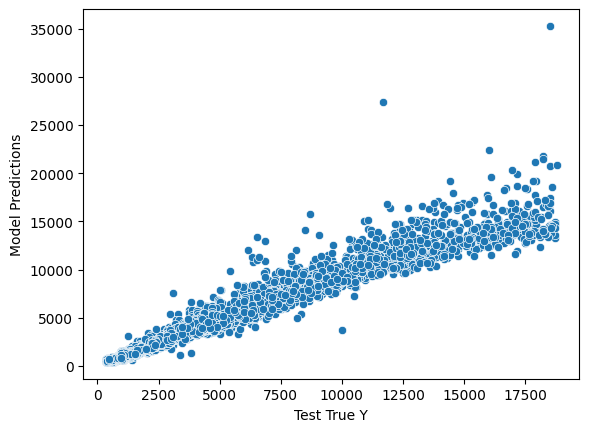

In [69]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

The falloff is now way less appearant after the 10 000$ mark. There are still a few strong outliers, but this is the best scatterplot we had up until this point. It does seem to lose track again after around 15 000$.

In [70]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
440.95 $

MSE
726974.44 $^2

RMSE:
852.63 $

R-squared:
0.96

Explained variance score:
0.96


These numbers are also the best we've had until now.

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


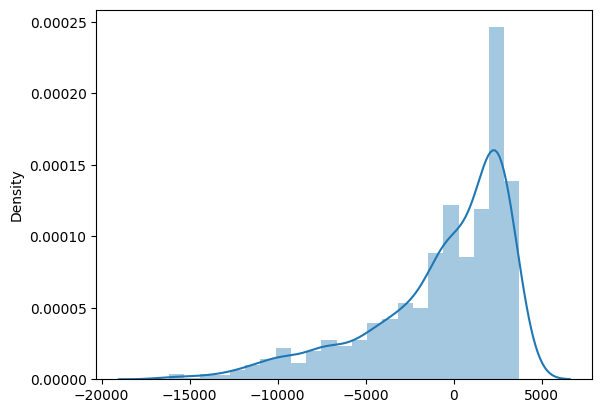

In [71]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

The problem with the distplot still remains, though the overpredicting is more balanced than before.

In [72]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [73]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [74]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Estimated price for this diamond:
659.85 $
----------------


The prediction is now higher than then the last two, it'S 370$ off, almost double the estimation. <br>
This could mean that this model is still very inacurrate or maybe the online tools are not that reliable <br>
It could still be that some type of diamonds just lost value in the time between the creation of the online tools and this dataset.

In [75]:
len(y_test)

8091

### Sixth model

Let's try to increase the node size.

In [76]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,969 (261.60 KB)

 Trainable params: 66,957 (261.55 KB)

 Non-trainable params: 12 (48.00 B)

In [77]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 10381072.0000 - val_loss: 1039677.7500
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1830698.5000 - val_loss: 817596.4375
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1856893.1250 - val_loss: 732282.6250
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1758416.2500 - val_loss: 706973.2500
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1627367.7500 - val_loss: 1029596.6875
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1795968.5000 - val_loss: 664521.6875
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1735221.0000 - val_loss: 681693.3750
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1692857.3750 - val_loss: 804107.1875
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1589653.3750 - val_loss: 642962.0625
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1621570.5000 - val_loss: 682026.4375
Epoch 

<Axes: >

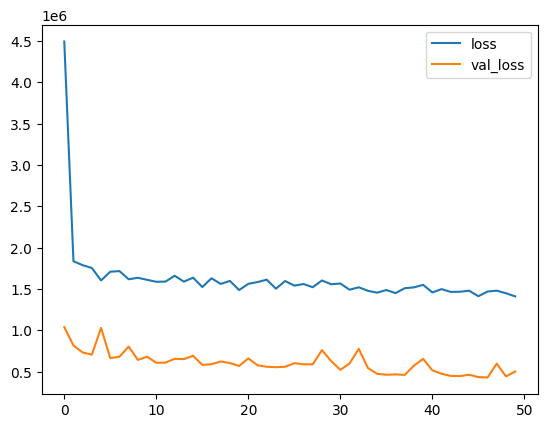

In [78]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

Not that much changed.

In [79]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
528796.0

Train data evaluation:
495422.75


These numbers are 130 000$ apart.

In [80]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Test True Y,Model Predictions
0,3407,3898.954346
1,11631,10463.341797
2,18741,15258.617188
3,2285,2369.374268
4,648,595.860657
...,...,...
8086,1985,1689.586792
8087,475,627.094543
8088,2351,2216.262451
8089,945,1131.397827


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

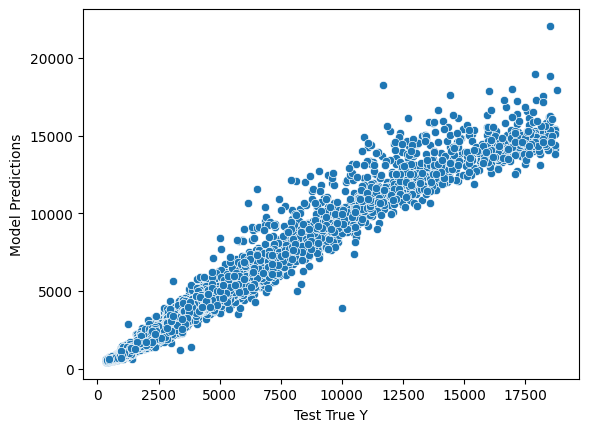

In [81]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

This scatterplot also seems to be more stable after 10 000$ but loses track after around 15 000$.

In [82]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
397.76 $

MSE
527789.72 $^2

RMSE:
726.49 $

R-squared:
0.97

Explained variance score:
0.97


These numbers didn't change that much, MAE and RMSE got a bit worse.

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


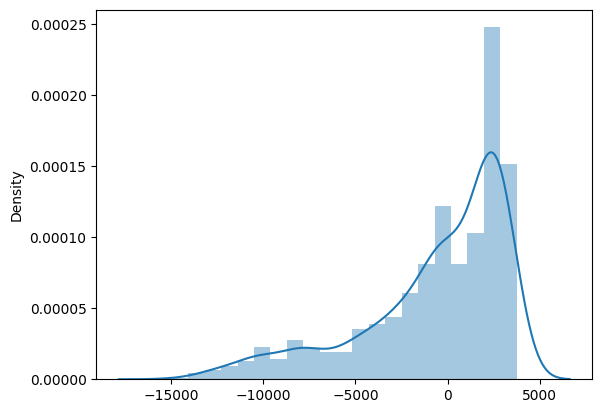

In [83]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

Still the same problem here.

In [84]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [85]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [86]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Estimated price for this diamond:
638.96 $
----------------


Yeah no, this estimation is also very off.

In [87]:
len(y_test)

8091

### Seventh model

Let's try to add a batch normalization after each layer. Since the batch normalization was able to make big changes in the beginning, I hope this could make a difference as well.

In [88]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 3rd layer reduces neuron count
        layers.BatchNormalization(),
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,017 (269.60 KB)

 Trainable params: 67,981 (265.55 KB)

 Non-trainable params: 1,036 (4.05 KB)

In [89]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 29623012.0000 - val_loss: 24540648.0000
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 21736356.0000 - val_loss: 13190500.0000
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 11071715.0000 - val_loss: 4728445.5000
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4016368.0000 - val_loss: 2178985.5000
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1829941.1250 - val_loss: 671177.8125
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1518185.8750 - val_loss: 3666046.7500
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1420893.7500 - val_loss: 1195390.6250
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1491746.2500 - val_loss: 10879757.0000
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1392270.2500 - val_loss: 1592449.6250
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1453874.8750 - val_loss: 1517924

<Axes: >

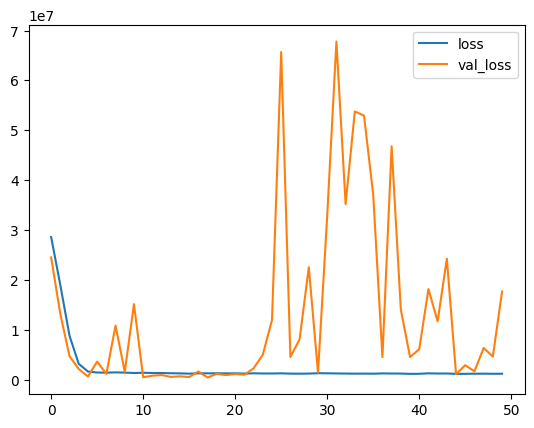

In [90]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

I'm not sure, but that does not look good.

In [91]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
19386468.0

Train data evaluation:
20252270.0


These numbers got worse.

In [92]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Test True Y,Model Predictions
0,3407,3891.985596
1,11631,10646.734375
2,18741,15652.739258
3,2285,2790.803223
4,648,973.232849
...,...,...
8086,1985,2365.807617
8087,475,936.228699
8088,2351,2511.702637
8089,945,1358.616333


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

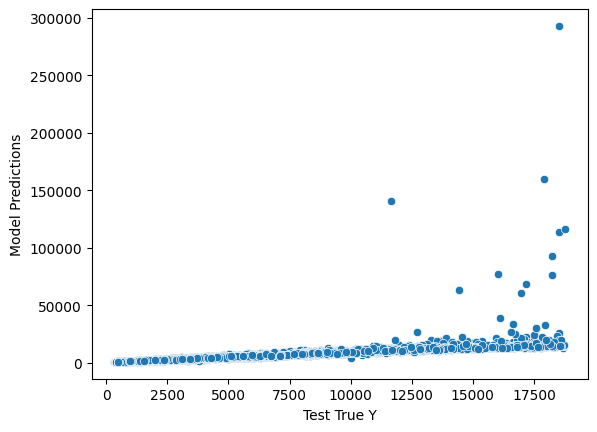

In [93]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

The scatterplot was also not very happy with the new model.

In [94]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
657.96 $

MSE
19385888.33 $^2

RMSE:
4402.94 $

R-squared:
-0.18

Explained variance score:
-0.17


How are these numbers even possible?

C:\Users\Startklar\AppData\Local\Temp\ipykernel_91332\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


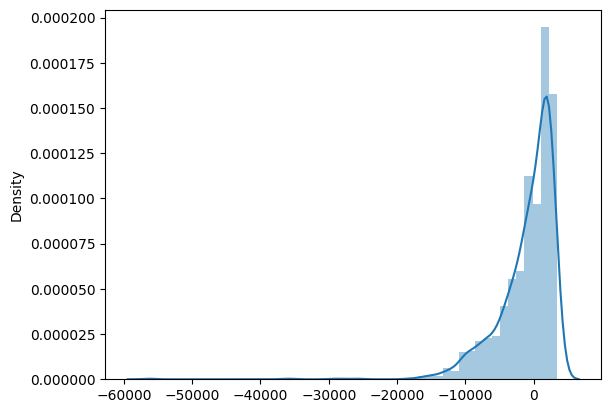

In [95]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

At least we now have a normal distribution, i guess.

In [96]:
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,4,5,1,61.5,55.0,326
1,0.21,3,5,2,59.8,61.0,326
2,0.23,1,5,4,56.9,65.0,327
3,0.29,3,1,3,62.4,58.0,334
4,0.31,1,0,1,63.3,58.0,335


In [97]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [98]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Estimated price for this diamond:
920.34 $
----------------


Hm, stacking batch normalization does not work out as well as I'd hoped.

In [99]:
len(y_test)

8091

## Closing thoughts

There seem to have been many problem that were shared between a lot of those models.<br>
I think most of these problems can be explained by real world standards. Since diamond pricing may not always follow these quality regulations. <br>
On many of the online tools, you could also observe some other factors that determine the price that were not included in this dataset. The online calculators also include the shape of the diamond, the fluoresence, polish, symmetry and if it is lab grown or natural.<br>
Like mentioned before, a big reason for these larger variances could also be, that there are other factors, not even included in the online calculators that determine the pricing of a diamond. Things like historical importance, luxury pricing, brands. Maybe even the expertise of the seller. <br>
There could also be some problems with the dataset, even though it has around 50 000 rows. Since the calculations often times got less accurate in the higher priced categories, it seems that the dataset does not have that many data for these price ranges.<br>

After all of these considerations, I believe that the fifth model is the most accurate model I have created. It did not guess the sample diamond correctly, but it otherwise has created the best stats.